In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import scvelo as scv
import scanpy as sc
import celldancer.utilities as cdutil
import numpy as np
import seaborn as sns

In [2]:
adata = scv.datasets.dentategyrus_lamanno()

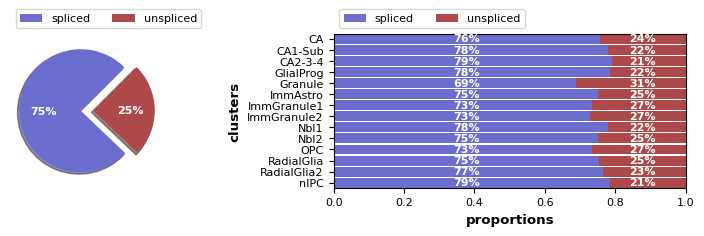

In [3]:
scv.pl.proportions(adata, groupby = "clusters")

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
cdutil.adata_to_df_with_embed(adata,
                              us_para = ['Mu','Ms'],
                              cell_type_para = 'clusters',
                              embed_para = 'X_tsne',
                              save_path = 'celldancer_predata.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.20it/s]


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Rgs20,0.058109,0.022597,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,Rgs20,0.005789,0.007674,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,Rgs20,0.052402,0.024085,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,Rgs20,0.037480,0.000000,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,Rgs20,0.015696,0.000000,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...
36425995,Erdr1,0.262918,0.132853,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
36425996,Erdr1,0.101641,0.170459,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
36425997,Erdr1,0.590749,0.282814,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
36425998,Erdr1,0.332591,0.067807,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


In [7]:
cell_type_u_s = pd.read_csv('celldancer_predata.csv')

In [8]:
loss_df, cellDancer_df = cd.velocity(cell_type_u_s, permutation_ratio = 0.125, n_jobs = 16)

Using /media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/dentategyrus_lamanno/cellDancer_velocity_2024-05-14 13-55-08 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  125  portions.



Velocity Estimation: 100%|██████████| 125/125 [17:25<00:00,  8.28s/it]                                                                                                                                           
                                                                                                                                                                                                                 

In [9]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

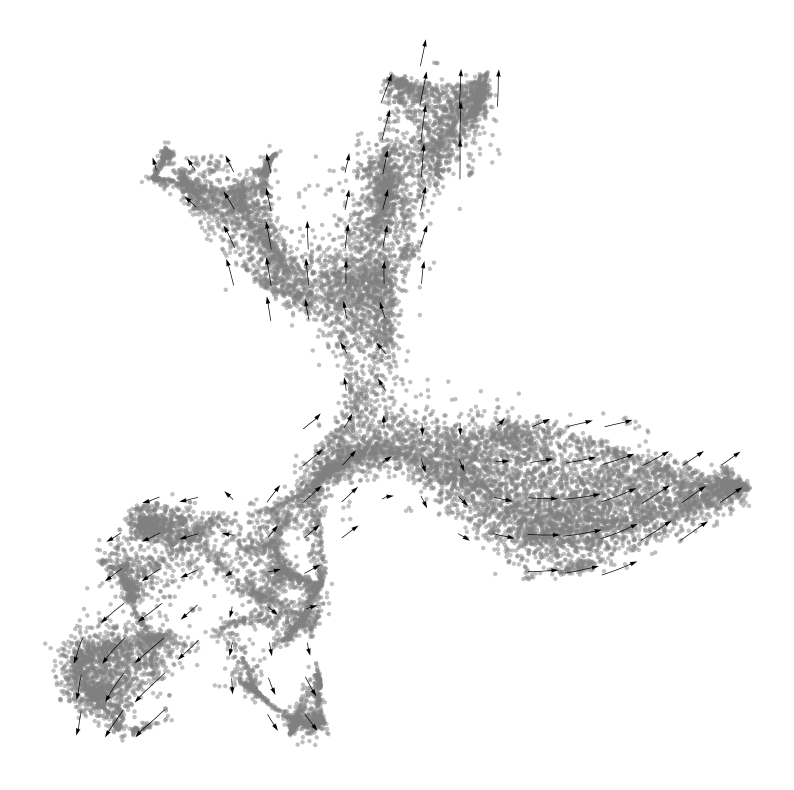

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
cdplt.scatter_cell(ax,
                   cellDancer_df,
                   alpha=0.5,
                   s=10,
                   velocity=True,
                   legend='on',
                   min_mass=5,
                   arrow_grid=(20,20))
ax.axis('off')
plt.show()

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19440/19440 [00:01<00:00, 14259.26it/s]


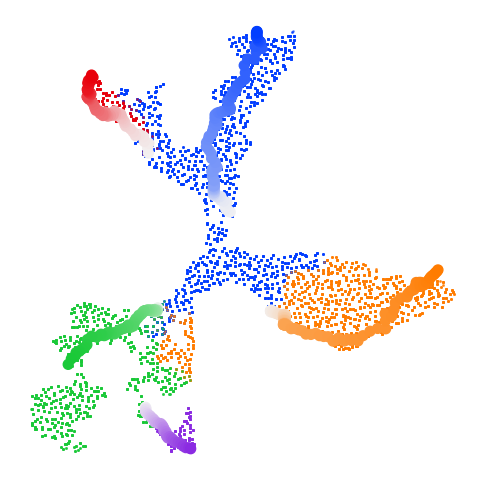

There are 5 clusters.
[0 1 2 3 4]
--- 294.188428401947 seconds ---


In [13]:
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 5,
                               plot_long_trajs=True,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

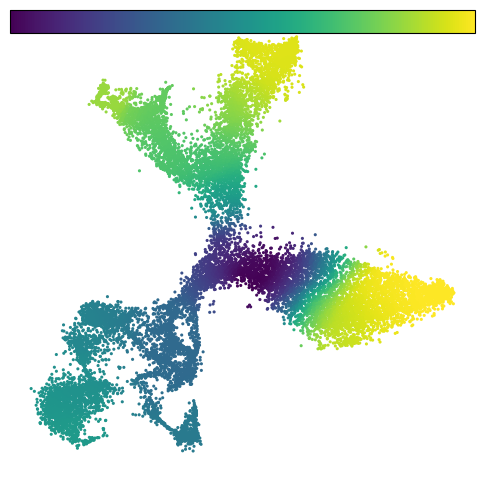

In [15]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=1.0, velocity=False)
ax.axis('off')
plt.show()

In [16]:
cellDancer_df.to_csv("data/celldancer_result.csv")

In [17]:
adata_celldancer = cdutil.to_dynamo(cellDancer_df)

In [18]:
adata_celldancer

AnnData object with n_obs × n_vars = 18213 × 2000
    obs: 'clusters'
    var: 'highly_variable_genes', 'loss', 'use_for_dynamics', 'use_for_transition'
    uns: 'dynamics'
    obsm: 'X_cdr', 'velocity_cdr'
    layers: 'X_spliced', 'X_unspliced', 'M_s', 'M_u', 'velocity_S', 'velocity_U', 'alpha', 'beta', 'gamma'
    obsp: 'connectivities', 'distances'

In [19]:
clusters = list(cellDancer_df["cellID"][0:18213])

In [20]:
times = list(cellDancer_df["pseudotime"][0:18213])

In [21]:
match_dict = {k:v for k, v in zip(clusters, times)}

In [22]:
cellID = adata_celldancer.obs_names

In [23]:
pseudotime = [match_dict[item] for item in cellID]

In [24]:
adata_celldancer.obs["pseudotime"] = pseudotime

In [25]:
adata_celldancer.write_h5ad("data/celldancer.h5ad")